# Sentinel2 QA pixel masking and Flood monitoring

This tutorial exercise we examine the removal of low quality pixels from Sentinel 2 satellite imagery. This is a common step in a image processing pipelines as most earth imagery come with quality information at the pixel level of in the form of a separate file or band. The user can leverage this information to mask low quality/bad pixels that relate various issues (distortion, cloudes etc.) depending on varioud criteria. We presents here a specific case using Sentinel 2 data we downloaded in previous tutorial (see processing and download).


# Data

We use data products from the Sentinel 2 Mission from the Copernicus programme. Sentinel 2 consists of two satellite platforms collecting imagery with the same multi spectral Imagery sensor. There are two satellites:

- Sentinel 2A was launched on June 23
- Sentinel 2B was launched on March 7 2017.

Sentinel 2 satellites have revisit time of 10 days under the same angles with higher revisit times in higher latitudes and more revisit times if we consider both Sentinel 2A and 2B together. Sentinel 2 data is distributed as granules (tiles) that are 100x100 km2 ortho-images in UTM/WGS84 projection.

Because the satellite path crosses the meridians the tiles collected are triangular or trapezoidal in shape and do not follow the UTM square gridding used to distribute the data.

# Abrupt Event

To explore the use of Sentinel 2 data, we use Vermont flooding that occured between July 9 and 11, 2023. This flood event had a major impact on the state with 14 counties declared as state disaster. River levels increased across the state and the Winooski River near Montpellier, the state capital, jumped by 14 feet within a 20 hour time period.


## Interesting links:

- GDAL tutorial:

https://www.kaggle.com/code/samanemami/a-complete-tutorial-on-raster-data-analysis?scriptVersionId=110771922

- STAC and COGS

Each pystac.Item <https://pystac.readthedocs.io/en/stable/api/pystac.html#pystac.Item>__ in this ItemCollection includes all the metadata for that scene. STAC Items are GeoJSON features, and so can be loaded by libraries like geopandas.

- course:

http://spatial-ecology.net/docs/build/html/WEBSEMINAR/webseminar.html

https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/

https://github.com/stac-utils/pystac-client/blob/df034494c2d566f0b2fa6fb8f0455f75d10e0b62/docs/tutorials/pystac-client-introduction.ipynb

https://kodu.ut.ee/~kmoch/geopython2019/L4/raster.html


- Analyzing sentinel 2 with GEE in python:

https://worldbank.github.io/OpenNightLights/tutorials/mod6_3_intro_to_sentinel2.html


- GDAL Time series

https://ucl-eo.github.io/geog0111/041_GDAL_timeseries_answers/


https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Catalog.html

https://gis.stackexchange.com/questions/178535/how-can-i-use-gdal-merge-with-multiple-files-in-one-folder-in-python-2-7


- Copernicus Dataspace Ecosystem

https://documentation.dataspace.copernicus.eu/APIs/STAC.html


- Visualize and explore multibands time series from Sentinel with xarray


https://medium.com/@bonnefond.virginie/handling-multi-temporal-satellite-images-with-xarray-30d142d3391

- NASA Earth data via STAC

https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/02_Data_Discovery_CMR-STAC_API.html

https://hls.gsfc.nasa.gov/products-description/tiling-system/

- Flooding datasets:

https://github.com/cloudtostreet/Sen1Floods11

- Flooding event in Vermont:

https://floodlist.com/america/usa/floods-vermont-july-2023

https://www.vermontpublic.org/2023-07-13/maps-which-areas-in-vermont-were-hit-hardest-in-this-weeks-flooding

https://maps.disasters.nasa.gov/arcgis/apps/MinimalGallery/index.html?appid=79638a63d4824520bb3360415b37a9bd

https://maps.disasters.nasa.gov/download/gis_products/event_specific/2023/vermont_flooding_202307/sentinel2/20230706/cir/

https://cimss.ssec.wisc.edu/satellite-blog/archives/53377


- visualizes the boundaries of the S-2 granules imaged on a single day.

https://gis.stackexchange.com/questions/395456/why-is-the-sentinel-2-image-plot-triangular-in-google-earth-engine


# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

First let's list a few parameters to understand the computing environment that we are using. In particular:
- os system
- python version
- hostname

In [ ]:
!uname -a
!lsb_release -a
!python --version
!hostname
!whoami

Linux cd8630454bd4 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
Python 3.10.12
cd8630454bd4
root


Let's then install GDAL binaries and spatial libraries necessary for gdal, rasterio and xarray.

In [ ]:
#install gdal to run from the terminal
!sudo add-apt-repository ppa:ubuntugis/ppa -y
!sudo apt-get update
!sudo apt-get install gdal-bin
!gdalinfo --version

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/ jammy main'
Description:
Official stable UbuntuGIS packages.


More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ppa.gpg with fingerprint 2EC86B48E6A9F326623CD22FFF0E7BBEC491C6A1
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubu

Install other geospatial related libraries

In [ ]:
#set up libararies for GIS/Geospatial
try: # try the following b+lock of code
  import geopandas as gpd
except: # if the try block throws an error, run the following
  !pip install geopandas # install geopandas
  import geopandas as gpd

try:
  import contextily as ctx # import
  import rasterio
except:
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  !pip install rasterio
try:
  import fiona # library for reading/writing GIS files, comes w/ geopandas
except:
  !pip install fiona
from shapely.geometry import Point, LineString, Polygon

!pip install pyproj
# Mapping,vector related imports
import geopandas as gpd
#import descartes #nessary for plotting in geopandas
from cartopy import crs as ccrs
from pyproj import Proj
#from osgeo import osr
from shapely import geometry
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon

from collections import OrderedDict
#rasterio imports, gdal and imagery utility
import rasterio
from rasterio.windows import Window
from osgeo import gdal
from rasterio import plot
from PIL import Image

#xarray and rio
!pip install rioxarray
!pip install mapclassify
!pip install earthpy

import mapclassify
import folium
import pyproj as proj
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
from folium.utilities import none_max
import folium
from pyproj import Transformer

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libproj-dev is already the newest version (9.1.1-1~jammy0).
proj-bin is already the newest version (9.1.1-1~jammy0).
proj-data is already the newest version (9.1.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


General purpose libraries and packages

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import subprocess
import pandas as pd
import os, glob
import zipfile

from pathlib import Path

sns.set_style('darkgrid')
#pd.set_option('display.max_colwidth', None)
!apt install unzip
import urllib
import re
import math
from datetime import datetime
from copy import deepcopy
from numpy.core.multiarray import datetime_as_string
import os
import numpy.ma as ma

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


In [ ]:
#Used in defining functions
from typing import List, Tuple, Dict, Any
from pandas.core.arrays import boolean

Install STAC related libraries

- https://pystac-client.readthedocs.io/_/downloads/en/stable/pdf/
- https://github.com/stac-utils/pystac-client/blob/df034494c2d566f0b2fa6fb8f0455f75d10e0b62/docs/tutorials/aoi-coverage.ipynb


In [ ]:
!pip install pystac
#!pystac_client
!pip install pystac-client
!pip install planetary-computer
import planetary_computer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
#GCP account authentification
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Functions
In the next part of the script, we declare all the functions used in the sripts.  It is good practice to place functions at the beginning of a script or in an external source file. Here are the 13 functions used:

In [ ]:
def create_dir_and_check_existence(path: str) -> str:
  '''
  Create a new directory

  :param path: path to the directory
  :return: path to the directory
  '''

  try:
    os.makedirs(path)
  except:
    print ("directory already exists")
  return path



In [ ]:
def dms_to_dd(val: np.float32) -> np.float32:
  '''
  Convert dms: degree minute second to decimal degree
  Note that the format expect direction with W or S.

  :param val: degree minute second
  :return: decimal degree
  '''

  deg,minute,second,direction = re.split('[°\'\"]', val)
  dd_val = float(deg)+float(minute)/60+float(second)/(60*60)
  if direction == 'W' or direction == 'S':
    dd_val = (-1.)*dd_val
  return dd_val

In [ ]:

def bbox_to_poly(bbox: list) -> Polygon:

  '''
  Convert bounding box list into a polygon. With input list xmin,ymin,xmax,ymax.

  :param bbox list: list of coordinates represending a bouding.
  :return: Shapely polygon

  '''

  long0 = bbox[0]
  lat0 = bbox[1]
  long1=bbox[2]
  lat1=bbox[3]

  poly = Polygon([[long0, lat0],
                        [long1,lat0],
                        [long1,lat1],
                        [long0, lat1]])

  return poly

In [ ]:
def polygon_from_centroid(x_centroid,y_centroid,size,EPSG_val=4326)-> gpd.GeoDataFrame:

  '''

  Generate a square polygon from center point with a given size and EPSG code
  Return a GeoDataFrame

  :param x_centroid float32: x center of square polygon being created
  :param y_centroid float32: y center of square polygon being created
  :param size float32: length of square polygon
  :param EPSG_val int: EPSG code defining the coordinate system
  :return geopandas geodataframe

  '''

  xmin = x_centroid - size/2
  xmax = x_centroid + size/2
  ymin = y_centroid - size/2
  ymax = y_centroid + size/2

  bbox_list = [xmin,ymin,xmax,ymax]
  bbox_poly = bbox_to_poly(bbox_list)

  bbox_poly_gdf = gpd.GeoDataFrame(pd.DataFrame(['p1'], columns = ['geom']),
         crs = {'init':f'epsg:{EPSG_val}'},
         geometry = [bbox_poly])
  bbox_poly_gdf.to_file('bbox_poly.shp')

  return bbox_poly_gdf

In [ ]:
#https://aws.amazon.com/blogs/apn/transforming-geospatial-data-to-cloud-native-frameworks-with-element-84-on-aws/
#https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb
def items_to_geodataframe(items: any) -> gpd.GeoDataFrame:
    '''
    Convert a list of STAC Items into a GeoDataFrame.
    Modified from https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb

    :param items: list of STAC Items
    :return: GeoDataFrame
    '''

    #Using from copy import deepcopy
    _items = []
    for i in items:
        _i = deepcopy(i)
        _i['geometry'] = shape(_i['geometry'])
        _items.append(_i)
    gdf = gpd.GeoDataFrame(pd.json_normalize(_items))
    for field in ['properties.datetime', 'properties.created', 'properties.updated']:
        if field in gdf:
            gdf[field] = pd.to_datetime(gdf[field])
    gdf.set_index('properties.datetime', inplace=True)
    return gdf

In [ ]:
from pystac_client import item_search
#https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb
def get_selected_products_and_bands(cat_search: item_search.ItemSearch,
                                    bands_selected: list[str],
                                    platform: str='Sentinel-2A') -> pd.DataFrame:

  '''
  Get the selected products and bands from STAC

  :param items: pystac_client item search object
  :param bands_selected: list of bands to filter
  :return: pandas data frame containing the selected products and bands
  '''

  items_dict = [i.to_dict() for i in cat_search.get_items()]
  print(f"{len(items_dict)} scenes fetched")
  items = items_to_geodataframe(items_dict)
  bands_selected = [f'assets.{b}.href'for b in bands_selected]
  bands_selected
  col_selected = bands_selected + ['collection','id','properties.s2:mgrs_tile','properties.proj:epsg']
  if platform is not None:
    selected_products = items.loc[items['properties.platform']==platform,col_selected] #filter for relevant platform
  else:
    selected_products = items.loc[:,col_selected] #filter for relevant platform

  selected_products = selected_products.reset_index()
  print(selected_products['properties.datetime'].dtypes)
  selected_products['date'] = selected_products['properties.datetime'].dt.date
  selected_products['date'] = selected_products['date'].astype(str)
  list_dates = list(selected_products['date'].unique())
  list_tiles = selected_products['properties.s2:mgrs_tile'].unique()

  return selected_products

In [ ]:
#Change the name of the file to include date and better formatting
#Also adjust the resolution
def download_and_reproject_stac_file(date_val:str,
                                     selected_products:pd.DataFrame,
                                     download: bool,
                                     aoi_poly:gpd.GeoDataFrame,
                                     output_epsg: int=None,
                                     output_res: np.float32=None,
                                     out_dir:str='.') -> str:
  '''
  Download and reproject STAC files

  :param date_val: str: date to download and process
  :param selected_products: pd.DataFrame
  :param download: boolean, if true download the raw file without processing
  :param aoi_poly: gpd.GeoDataFrame containing the reference poygon of Area of Interest
  :param output_epsg: int code for EPSG projection coordinate system
  :param output_res: np.float32 resolution of output raster
  :param out_dir: str path to output directory
  :return: output raster file name containing the processed raster
   '''

  bands_cols = list(selected_products.filter(regex='assets').columns)

  for band in bands_cols:
    if download is True:
        raster_file_list = selected_products.loc[selected_products['date']==date_val,band].tolist()
        out_raster_file =[]
        for raster_file in raster_file_list:
           download_path = os.path.join(selected_products.collection)
           in_filename = raster_file
           out_filename = os.path.basename(in_filename.split('?'))[0] #split the name on ?
           os.makedirs(download_path, exist_ok=True)
           out_filename = os.path.join(out_dir,out_filename)
           urllib.request.urlretrieve(in_filename,
                                   out_filename)

           out_raster_file.append(out_filename)

    #crop and project if download is false
    if download is False:

      # Set the AOI cropping
      proj_crs = selected_products.loc[selected_products['date']==date_val,'properties.proj:epsg'].tolist()
      print(proj_crs) #this is the EPSG code
      aoi_poly_proj = aoi_poly.to_crs(f'EPSG:{proj_crs[0]}') #should first extract current EPSG!!
      aoi_poly_proj.to_file('aoi_poly_proj.shp')
      aoi_poly_proj.crs

      #Set the resolution for the ouput
      if output_res is None:
        #if unit is degree we need to call a function
        #if not we use the same res as input
        output_res=0.00009
        #this still needs to be improve
        #use input raster to match the res in the output projection given
      if output_epsg is None:
        crs_val=(aoi_poly.crs.srs)
        epsg_code = crs_val.split(':')[1][:4]
        output_epsg = f'EPSG:{epsg_code}'
      data_val_formatted = date_val.replace("-","")

      download_path = os.path.join(selected_products.collection.unique()[0],
                                    data_val_formatted)
      os.makedirs(download_path, exist_ok=True) # add date

      out_filename=os.path.join(out_dir,
                                download_path, #add date in output path?
                                f'crop_proj_{selected_products2.collection.unique()[0]}_{band}_{data_val_formatted}.tif')
      raster_file_list = selected_products.loc[selected_products['date']==date_val,band].tolist()

      #from pathlib import Path
      out_filename_vrt = Path(out_filename).stem

      raster_file_list_m = [f'/vsicurl/{u}' for u in raster_file_list]

      ds = gdal.BuildVRT( f'{out_filename_vrt}.vrt',
                         raster_file_list_m,
                          VRTNodata=0,
                          srcNodata=0)

      #dstSRS should not be hard coded
      result = gdal.Warp(out_filename,
                          ds,
                          format='GTiff',
                          dstNodata=0,
                          dstSRS= output_epsg, #this should not be hard coded
                          cutlineDSName='aoi_poly_proj.shp',
                          cropToCutline=True,
                          xRes=output_res, #this should not be hard coded
                          yRes=output_res)
      result=None
      out_raster_file = out_filename

  return out_raster_file

In [ ]:
#https://gis.stackexchange.com/questions/290796/how-to-edit-the-metadata-for-individual-bands-of-a-multiband-raster-preferably
def update_description_gdal(filepath: str,
                            list_desc: List) -> str:

  '''
  Update the description of a raster file using GDAL

  :param filepath: path/virtual path/uri to raster
  :param list_desc: list of string values for each band description, eg dates
  :return: str stating that the description was updated
  '''

  ds_src = gdal.Open(filepath, gdal.GA_Update)
  i=0
  for desc_val in list_desc:
    i=i+1
    rb = ds_src.GetRasterBand(i)
    rb.SetDescription(desc_val)
  del ds_src
  return "updated descriptions"

In [ ]:
## Now set no data and description + recalculate stats after that

def update_nodata_val_raster(in_filename: str,
                             band_val: int=1,
                             nodata_val: int=0) -> str:
  '''
  Update the nodata value of a raster file using GDAL

  :param in_filename: path to raster filep
  :param band_val: band number
  :param nodata_val: nodata value to set
  :return: str stating that the description was updated

  '''

  ds = gdal.Open(in_filename,1) # The 1 means that you are opening the file to edit it)
  rb = ds.GetRasterBand(band_val) #assuming your raster has 1 band.
  rb.SetNoDataValue(nodata_val)
  rb= None
  ds = None
  return 'Nodata value updated'

In [ ]:
def generate_qa_table_sentinel2() -> pd.DataFrame:

  '''

  Generate a reference table wtih value and corresponding label description for Sentinel 2
  Quality Pixel from teh Scene Land Classificaiton

  :return DataFrame with SCL description
  '''

  #https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html
  #https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

  from io import StringIO, BytesIO

  text_string = StringIO("""value,class,HTLM color code
  0,No Data (Missing data),#000000
  1,Saturated or defective pixel,#ff0000
  2,Dark features/Shadows',#2f2f2f
  3,Cloud shadows,#643200
  4,Vegetation,#00a000
  5,Not-vegetated,#ffe65a
  6,Water,#0000ff
  7,Unclassified,#808080
  8,Cloud medium probability,#c0c0c0
  9,Cloud high probability,#ffffff
  10,Thin cirrus,#64c8ff
  11,Snow or ice,#ff96ff
  """)
  SCL_legend_df = pd.read_csv(text_string, sep=",")

  return  SCL_legend_df

In [ ]:
def generate_apply_qa_raster_sentinel2(mask_values: List[int],
                                       input_filename_qa: str,
                                       input_filename_var: str,
                                       output_filename: str,
                                       in_dir: str,
                                       max_val: int = 10000,
                                       out_dir: str ='.'
                                       ) -> tuple[str,str]:

  '''
  Apply masking of qa pixel values on Sentinel 2 product.
  Users profiles a list of values to mask.

  :param mask_values: list of values to mask
  :param input_filename_qa: input filename containing SCL QA pixel values
  :param input_filename_var: Sentinel 2 band product filename e.g. B03 reflectance band
  :param in_dir: input directory containing files
  :param out_dir: output directory for files
  :return tuple cmd_str, output_filename

  '''
  df_legend_SCL =generate_qa_table_sentinel2()
  df_legend_SCL['valid']=df_legend_SCL.apply(lambda x: 0 if x.value in mask_values else 1,axis=1)#df2 = df.apply(lambda x: np.square(x) if x.name in ['A','B'] else x)
  df_legend_SCL['valid']
  list_pix_val = df_legend_SCL['value'].tolist()
  list_valid = df_legend_SCL['valid'].tolist()

  if max_val is None:
    max_val = 65536 #this will take all the value below the max for uint16

  os.chdir(in_dir)


  list_args =['gdal_calc.py',
              f'-A {input_filename_qa}',
              f'-B {input_filename_var}',
              '--A_band=1',
              '--B_band=1',
              f'--calc="(A=={list_pix_val[0]})*{list_valid[0]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[1]})*{list_valid[1]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[2]})*{list_valid[2]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[3]})*{list_valid[3]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[4]})*{list_valid[4]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[5]})*{list_valid[5]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[6]})*{list_valid[6]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[7]})*{list_valid[7]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[8]})*{list_valid[8]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[9]})*{list_valid[9]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[10]})*{list_valid[10]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[11]})*{list_valid[11]}*(B<={max_val})*B"',
              '--hideNoData',
              '--overwrite',
              '--outfile',
              f'{output_filename}']

  cmd_str = ' '.join([str(elem) for elem in list_args])
  #print(cmd_str)
  import subprocess
  env = os.environ.copy() #this is necessary in google colab
  output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
  #print(output_sub)
  #os.chdir(out_dir)

  return cmd_str, output_filename


In [ ]:
def freq_array(r: str|rasterio.io.DatasetReader,
               band_number: int=1) -> pd.DataFrame:

  '''
  Compute unique values and frequency for raster input.

  :param r: input raster filename or rasterio dataset
  :param band_number: band number for rasterio dataset
  '''
  if isinstance(r,rasterio.io.DatasetReader):
    r = r.read(band_number)
  unique, counts = np.unique(r, return_counts=True)
  unique_val = np.asarray((unique, counts)).T
  unique_val_df = pd.DataFrame(unique_val,columns=['value','count'])
  return unique_val_df

In [ ]:
def extract_proj_unit(epsg_val: int =4326) -> pd.DataFrame:

  '''
  Extract unit used in Coordinate Reference System identified by the EPSG code
  provided.

  :param  epsg_val: EPSG code value for coordinate reference system
  :return data frame containing unit, direction, name of CRS
  '''

  pyproj_crs = proj.CRS.from_epsg(epsg_val)
  list_unit_crs = [ai.unit_name for ai in pyproj_crs.axis_info]
  list_name_crs = [ai.name for ai in pyproj_crs.axis_info]
  list_direction_crs = [ai.direction for ai in pyproj_crs.axis_info]
  list_abbrev_crs = [ai.abbrev for ai in pyproj_crs.axis_info]
  proj_unit_df = pd.DataFrame.from_dict({"unit":list_unit_crs,
                        "name": list_name_crs,
                        "abbrev": list_abbrev_crs,
                        "direction": list_direction_crs})
  #https://gis.stackexchange.com/questions/299759/where-to-lookup-the-units-associated-with-epsg-code

  return proj_unit_df

In [ ]:
def match_spatial_resolution(aoi_poly: gpd.GeoDataFrame,
                             in_file_raster: str,
                             epsg_raster: int =None,
                             epsg_poly: int=None) -> float:
  '''
  Match spatial resolution of the input raster given a geopandas data frame for the AOI polygon.

  :param aoi_poly geodataframe corresponding to the area of interest.
  :param in_file_raster: name of input raster file
  :param epsg_raster: EPSG code for raster, if None read for input raster
  :param epsg_poly: EPSG code for AOI polygon, if None read from input AOI geodataframe

  '''

  print(raster_file_list[0])
  ds_r = rasterio.open(in_file_raster)
  res_x= ds_r.transform.a
  res_y= ds_r.transform.e
  if epsg_raster is None:
    epsg_val_r = ds_r.crs.to_epsg()

  if epsg_poly is None:
    crs_val=(aoi_poly.crs.srs)
    epsg_val_poly = crs_val.split(':')[1][:4]

  r_unit_df = extract_proj_unit(epsg_val_r)
  poly_unit_df = extract_proj_unit(epsg_val_poly)

  unit_r = np.unique(r_unit_df.unit.values)[0]
  unit_poly = np.unique(poly_unit_df.unit.values)[0]

  if (unit_poly=='degree') and (unit_r=='metre'):
    ratio_km = 1000/res_x
    output_res = round((1/111)/ratio_km, 5)
  if (unit_poly=='degree') and (unit_r=='degree'):
    output_res = res_x
  if (unit_poly=='metre') and (unit_r=='metre'):
    output_res=res_x
  return output_res

In [ ]:
def plot_raster_categories(in_filename: str,
                           color_list: List =None,
                           class_names: List[str]=None,
                           title_str: str=None)->str:
  '''
  Plot categorical raster given input file name

  :param in_filename: input file name
  :param color_list: list of colors for categories plotted
  :param class_names: list of categories names
  :title_str: title for the plot
  :return title_str: 'plotted' message
  '''

  if title_str is None:
    title_str =""
  sns.set(font_scale=1.5, style="whitegrid")

  ## Loading TIF file
  r_rxr = rxr.open_rasterio(in_filename,
                            masked=True).squeeze()
  r_rxr = r_rxr.astype('uint16')

  ### Getting unique classes from array and setting color and legend list

  classes_rxr = list(np.unique(r_rxr).astype('int'))
  n_classes = len(classes_rxr)
  # Plot newly classified and masked raster
  if color_list is None:
    color_list = sns.color_palette("pastel",n_classes)
    color_list =list(color_list.as_hex())
  if class_names is None:
    class_names = ['class_' + str(i) for i in classes_rxr]


  cmap_val = ListedColormap(color_list) #from matplotlib.colors
  f, ax = plt.subplots(figsize=(12,6))
  im = ax.imshow(r_rxr,
                cmap = cmap_val)
  ax.set(title=title_str)
  ep.draw_legend(im,
                titles = class_names,
                classes = classes_rxr)
  ax.set_axis_off()
  plt.show()

  return 'plotted'


In [ ]:
def update_raster_band_stats(in_filename: str,
                             band_val: int =1) -> pd.DataFrame:

  '''

  Update raster file stats using GDAL

  :param in_filename: input file name
  :param band_val: band value to be updated
  :return df_stats: DataFrame containing statistics including min,max,mean and std.

  '''
  ds = gdal.Open(in_filename,1) # The 1 means that you are opening the file to edit it)
  rb = ds.GetRasterBand(band_val) #assuming your raster has 1 band.
  stats =   rb.GetStatistics(0,1)
  rb= None
  ds = None
  df_stats = pd.DataFrame({'min':[stats[0]],
                          'max':[stats[1]],
                          'mean':[stats[2]],
                          'std':[stats[3]]})
  return df_stats

In [ ]:
#Create  function to create a time series
#Need to add the description

def generate_time_series_raster(file_pattern: str,
                                 in_dir: str,
                                 dstNodata_val: int=None,
                                 srcNodata_val: int=None,
                                 out_suffix: str=None,
                                 out_dir: str=".") -> tuple[str,str,pd.DataFrame]:

  '''

  Create a time series multiband raster file, vrt and data frame with list of corresponding files. This functions
  will create a list of input band fiel corresponding to each time step.

  :param file_pattern: pattern to match in file name
  :param in_dir: input directory
  :param dstNodata_val: integer value use for No Data output file
  :param srcNodata_val: integer value use for No Data input file
  :param out_suffix: output suffix
  :param out_dir: output directory
  :return out_file_raster: output raster file
  :return out_file_vrt: output vrt file
  :return df_files_raster: data frame with list of corresponding files.

  '''

  path_raster = os.path.join(in_dir,file_pattern) #raw raster
  files_raster_sat = glob.glob(path_raster,recursive=True)

  #we need to order the dates
  df_files_raster = pd.DataFrame({'files':files_raster_sat})
  df_files_raster['date'] = (df_files_raster['files'].str.split("_").str[-1]).str.replace(".tif","")
  df_files_raster['date'] = (pd.to_datetime(df_files_raster['date']))
  df_files_raster = df_files_raster.sort_values(by='date')
  df_files_raster = df_files_raster.reset_index(drop=True)

  if out_suffix is None:
    out_file_vrt = os.path.join(out_dir,f"time_series.vrt")
  else:
    out_file_vrt = os.path.join(out_dir,f"{out_suffix}_time_series.vrt")

  files_raster = df_files_raster['files'].tolist()

  if (dstNodata_val is None) and (srcNodata_val is None):
    ds_ts = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          callback=gdal.TermProgress_nocb)
  else:
    ds_ts = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          VRTNodata=dstNodata_val,
                          srcNodata=srcNodata_val,
                          callback=gdal.TermProgress_nocb)

  ds_ts.GetDescription()

  #InputImage = gdal.Open(VRT, 0)  # open the VRT in read-only mode
  if out_suffix is None:
    out_file_raster = os.path.join(out_dir,f"time_series.tif")
  else:
    out_file_raster = os.path.join(out_dir,f"{out_suffix}_time_series.tif")

  gdal.Translate(out_file_raster,
                ds_ts,
                format='GTiff',
                creationOptions=['COMPRESS:DEFLATE', 'TILED:YES'],
                callback=gdal.TermProgress_nocb)
  del ds_ts   # close the VRT

  return out_file_raster, out_file_vrt,df_files_raster


In [ ]:
#this is coming from:
#https://github.com/bparment1/rastermodel/blob/master/rastermodel/rastermodeling.py

def raster_compute_proportion(rast_in: str | list,
                              nodata_val: int=-9999,
                              out_nodata_val: int=0,
                              dtype_val: str=None,
                              out_filename: str=None,
                              out_dir: str =None,
                              count_val: str =None,
                              val=4) -> str:
    '''

    Compute proportion of pixels in a raster

    :param rast_in: input raster
    :param nodata_val: nodata value
    :param out_nodata_val: output nodata value
    :param dtype_val : data type for output
    :param out_filename: output file name
    :param out_dir: output directory
    :param count_val: count value
    :param val: value to compute proportion
    :return: out_filename: output file name

    '''

    if out_dir is not None:
      out_filename = os.path.join(out_dir,out_filename)

    ## Check for type:
    if(type(rast_in)==list):
        src_RP1 = rasterio.open(rast_in[0])
        src_RP =  list(map(lambda x: rasterio.open(x) , rast_in))
        n_layers = len(src_RP)
    else:
        src_RP1 = rasterio.open(rast_in)
        n_layers = 1

    #Add multiband support:
    if(src_RP1.count >1):
        n_layers= src_RP1.count

    ## Option  to set the dtype from the predicted val??
    ## Check if file exists first, still a problem here

    exists = os.path.isfile(out_filename)

    if exists:
        print("File already exists, removing file")
        os.remove(out_filename)

        out_profile = src_RP1.profile.copy()

        if dtype_val!= None:
            nodata_val = rasterio.dtypes.dtype_ranges[dtype_val][0] #take min val of range
            out_profile['dtype']=dtype_val
            out_profile['nodata']=nodata_val
        if count_val is not None:
          out_profile['count']= count_val
        dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)
    else:
        print("creating file")
        out_profile = src_RP1.profile.copy()
        if dtype_val!= None:
            nodata_val = rasterio.dtypes.dtype_ranges[dtype_val][0] #take min val of range
            out_profile['dtype']=dtype_val
            out_profile['nodata']=nodata_val
        if count_val is not None:
          out_profile['count']= count_val
        dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)

    i=0
    #src_RP1.block_windows(1) use 1 to have alll the bands included
    for block_index, window in src_RP1.block_windows(1):
        i = i  + 1 #tracking if this is the first window
        RP1_block = src_RP1.read(window=window, masked=True)
        #print(RP1_block.shape)

        if(type(rast_in)==list):
            RP_block =  list(map(lambda x,window: x.read(window=window, masked=True) , src_RP,repeat(window)))
            RP_block =  list(map(lambda x: x.ravel() , RP_block))
            RP_block =  np.stack(RP_block, axis=1)
        else:
            RP_block = RP1_block
            #RP_block = RP_block.ravel() #only sample of the form (20,), missing feature
            #RP_block = RP_block.reshape(-1,1)

        shape_block = RP1_block.shape #need with and heigt

        if dtype_val!= None:
            RP_block = RP_block.astype(dtype_val)

        result_block = proportion_pix(
            pix=RP_block,
            val=val)

        #if this i the first window blocked processed check that the data type match
        #the output and array computed
        #could also check the count or with and heigth
        if i ==1:
          #check the out_profile:
          if (result_block.dtype != out_profile['dtype']) or (result_block.count != out_profile['count']) :
            out_profile['dtype'] = result_block.dtype
            out_profile['count'] = result_block.shape[0]
            dst.close()
            os.remove(out_filename)
            dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)

        dst.write(result_block, window=window)

    src_RP1.close()
    if(type(rast_in)==list):
      out_close = list(map(lambda x: x.close(), src_RP))
    dst.close()

    return out_filename

In [ ]:
def proportion_pix(pix: np.array,
                   val: int) -> np.array:

  '''
  Compute the proportion of pixel with a specific value in a numpy array

  :param pix: numpy array containing values to be matched
  :param val: value to match in the array to calcuate the proportion
  :return

  '''
  pix_bool = np.where(pix==val,1,0)
  prop = np.nanmean(pix_bool,axis=(0),keepdims=True)
  return prop


In [ ]:
def create_RGB(in_filename: str,
               out_filename :str,
               scale_list: str,
               out_dtype: str ='Byte') -> list[str,str]:

  '''

  Create RGB raster image from input a VRT file. This will compute the band statistics and scale values to visualize
  RGB using stretch (rescaling) with gdal_translate.

  :param in_filename: multiband input filename containing RGB band in the Red, Green and Blue order
  :param out_filename: output file name
  :param scale_list: list containing value of min and max trehsold to consider for streachign.

  '''

  if out_dtype=='Byte':
    min_val=0
    max_val=255
  if out_dtype=='Float32':
    min_val=0
    max_val=1

  if scale_list is None:
    ds = gdal.Open(in_filename)
    stats=ds.GetRasterBand(1).GetStatistics(0,1)
    print(stats)
    list_df_stats_RGB = []
    for band_val in (1,2,3):
      df_stats_val = update_raster_band_stats(in_filename,band_val=band_val)
      list_df_stats_RGB.append(df_stats_val)

    df_stats_RGB = pd.concat(list_df_stats_RGB).reset_index()

  list_args = ['gdal_translate',
              f'-scale_1 {str(df_stats_RGB.loc[0,["min"]].values[0])} {str(df_stats_RGB.loc[0,["max"]].values[0])} {min_val} {max_val}',
              f'-scale_2 {str(df_stats_RGB.loc[1,["min"]].values[0])} {str(df_stats_RGB.loc[1,["max"]].values[0])} {min_val} {max_val}',
              f'-scale_3 {str(df_stats_RGB.loc[2,["min"]].values[0])} {str(df_stats_RGB.loc[2,["max"]].values[0])} {min_val} {max_val}',
              f'-ot {out_dtype}',
              in_filename,
              out_filename]
  cmd_str = ' '.join([str(elem) for elem in list_args])
  import subprocess
  env = os.environ.copy() #this is necessary in google colab
  output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)

  return out_filename,cmd_str

In [ ]:
#from datetime import datetime
#from typing import Tuple
def find_target_dates(list_dates: List,
                      event_date: str) -> tuple[str, str]:

  '''

  Find date before and after event given a list

  :param list_dates: list of dates to use
  :param event_date: target date of specific event to match
  :return date_selected_before: closest date before target event
  :return date_selected_after: closest date after target event

  '''

  #print(event_date)
  target_date = datetime.strptime(event_date,'%Y-%m-%d')
  #print(type(target_date))
  date_selected_str=min(list_dates, key=lambda x: (datetime.strptime(x,'%Y-%m-%d')>target_date, abs(datetime.strptime(x,'%Y-%m-%d')-target_date)) )
  #print(type(date_selected_str))
  date_selected = datetime.strptime(date_selected_str,'%Y-%m-%d')
  if target_date > date_selected:
    date_selected_before = date_selected_str
    date_selected_after = list_dates[list_dates.index(date_selected_str) + 1]
  else:
    date_selected_after = date_selected_str
    date_selected_before = list_dates[list_dates.index(date_selected_str) -1]

  return date_selected_before, date_selected_after

In [ ]:
#get list of coordinates for each polygon from geometry list
def coord_lister(geom: gpd.GeoDataFrame.geometry) -> List:

  '''
  Convert polygon geometry to list of coordinates

  :param geom: polygon geometry to convert into list of coordinates.
  :return list of tuple coordinates for the exterior ring of the polygons.

  '''

  #Should probably check that we have a polygon object
  coords = list(geom.exterior.coords)
  return coords

In [ ]:
def convert_window_block_to_poly(ds: str|rasterio.io.DatasetReader) -> gpd.GeoDataFrame:

  '''
  Convert raster chunk blocks into polygon

  :param ds: rasterio dataset or string of input file name
  :return Geodataframe containing all chunk location as polygon

  '''

  if not isinstance(ds,rasterio.io.DatasetReader):
    ds = rasterio.open(ds)
  ds_block_windows = ds.block_windows()
  list_df_window_coords =[]
  for index_window, window_val in ds_block_windows:
    row_offset,col_offset,width_val,height_val = window_val.flatten()
    x_offset_l_top,y_offset_l_top = ds_ndvi.xy(row_offset,
                                                  col_offset) #topleft of image chip

    x_offset_r_bottom,y_offset_r_bottom = ds_ndvi.xy(row_offset+width_val,
                                                        col_offset+height_val)
    df_window_coords_val = pd.DataFrame({
    "minx": [x_offset_l_top],
    "miny": [y_offset_l_top],
    "maxx": [x_offset_r_bottom],
    "maxy": [y_offset_r_bottom],
    "col_l_top": [col_offset],
    "row_l_top": [row_offset],
    "col_r_bottom":col_offset+height_val,
    "row_r_bottom":row_offset+width_val})

    bbox_val = [df_window_coords_val['minx'].values[0],
         df_window_coords_val['miny'].values[0],
         df_window_coords_val['maxx'].values[0],
         df_window_coords_val['maxy'].values[0]]

    poly_val= shapely.geometry.box(*bbox_val, ccw=True)
    df_window_coords_val['geometry']=poly_val
    df_window_coords_val
    #add pixel coordinates and polygon in geom column
    gdf_window_coords_val = gpd.GeoDataFrame(df_window_coords_val,geometry='geometry')


    list_df_window_coords.append(gdf_window_coords_val)

  gdf_window_coords = pd.concat(list_df_window_coords).reset_index(drop=True)

  return gdf_window_coords

In [ ]:
def plot_time_series(df :pd.DataFrame,
                     col_name: str='mean',
                     event_date: str = None,
                     date_col: str=None,
                     label_y: str='NDVI',
                     title: str=None,
                     out_filename: str=None,
                     out_dir: str=None,
                     save_fig: bool=False) -> str:
  '''
  Plot time series given column defining date and y data

  :param df : dataframe containing relevant column to plot
  :param col_name: name of the column to plot
  :param event_date: optional event date to add on time series plot
  :param date_col: optional column name definining the date
  :param label_y: label used for for the y-axis
  :param title: title of the plot if None it is auto generated
  :param out_filename: output file name for the plot
  :out_dir: output path dir to save file in
  :param save_fig: if True save figure plotted in a file

  '''

  df = df.reset_index()
  df['year']=df['date'].dt.year
  list_year = list(df['year'].unique())
  min_year = list_year[0]
  max_year =  list_year[-1]
  list_year = ["".join([str(year_val),'0101']) for year_val in list_year]

  if title is None:
    title = f'{label_y} over {min_year}-{max_year}'

  f, ax = plt.subplots(figsize=(11, 7))
  df.plot(x='date',
          y=col_name,
          ax=ax,
          marker='o')

  ax.legend(labels=[label_y],prop={'size':8})
  ax.set_title(title)
  ax.set_ylabel(label_y)
  ax.axhline(0, color="red", linestyle="--")
  for year_val in list_year:
    ax.axvline(year_val,color="red",marker='o',linestyle="--")
  ax.axvline(event_date, color="green",marker='o',linestyle="--")

  if save_fig is True:
    if out_filename is None:
      from datetime import datetime
      date_val=datetime.now().date().strftime('%Y_%m_%d')
      out_filename = f'time_series_{min_year}_{max_year}_{label_y}_{date_val}.png'
    plt.save_fig(out_filename,dpi=300)

  return out_filename


# Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).


In [ ]:
############################################################################
#####  Parameters and argument set up ###########

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/data/'
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011'
#ARG 2
out_dir = "/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARG 4
out_suffix = "n5_QA_VT_flooding_sentinel2_20241016" #output suffix for the files and ouptut folder
#out_suffix = "VT_flooding_stac_processing_sentinel2_20231011" #output suffix for the files and ouptut folder
#ARG 5
NA_value = -9999 # currently not used: Nan value
#ARG 6
random_seed=105 # set seed for reproducibility of results

#in_filename_roi = 'gadm41_USA_2.json'
in_filename_roi = None

period_freq = '5D' #use 5 days means that we using both Sentinel 2A and 2B
#bbox=[-72.8, 43.5, -72.7, 43.6] #xmin,ymin,xmax,ymax
bbox = None
convert_to_dms = True
#centroid_val = [ 43.750,-73.132]
centroid_val= ['''44°20'11.5"N''', '''72°45'21.2"W''']
infilename_= 'Sentinel2_level2A_band_description.csv'
processing_files=False
#processing_files=True #if True then crop, reproject and download
mask_values = [0,1,8,9]

#Args for STAC
start_date = '2021-01-01'
end_date = '2023-10-10'
image_collections = "sentinel-2-l2a"#can be landsat or anything of interest
URL = 'https://planetarycomputer.microsoft.com/api/stac/v1' #STAC API URL
#'https://earth-search.aws.element84.com/v0'

#band selected for processing
bands_selected = ['B02','B03','B04','B05','B06','B07','B08','B09','B11','B12','B8A','SCL']
platform='Sentinel-2A'
platform= None

event_date = '2023-07-10'
add_description = False

In [ ]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


In [ ]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_n5_QA_VT_flooding_sentinel2_20241016


#0.Intro to Sentinel 2 data and sensor instruments

Sentinel 2 sensor collects information using the Multi Spectral Instrument, MSI, in 13 spectral bands in the visible, infrared and short wave ifrared. Spatial resolution ranges from 10 m (four bands), 20 m (6 bands) and 60m (3 bands).The central wavelength spans from 400nm to 2200 with a a variety of band width as visible in the table below.

Each band provides useful information on group features with a focus on land use and land cover monitoring, environmental climate change applications and disaster/emergency monitoring . For instance Green, Red and NIR can provide useful information on vegetation health and land cover changes. Individual spectral bands are often compbined together by creating indices that are better at monitoring specficic feature (e.g. NDVI).

There are three user products provided by the Copernicus program and the Sentinel 2 missions:
- Level 1B: Top of The Atmospher radiance in sensor geometry.
- Level 1C: Top of the Atmosphere reflectance in cartographic geometry.
- Level 2A. Top of the Atmosphere reflectance in cartographi geomgetry

Below we show Sentinel level 2A data products provided to the users. It is distributed in 13 seperate files using 16 bit unsigned integer (uint16) with a reflectance range of 1-10000. No data values are coded as 0. No reflectance bands are have different valid range. The SCL band (Scene Classification Layer) provides information on pixel quality and basic broad land cover classes and clouds.

Data is provided in a 110kmx110 km granule tile format matching the UTM grids. Since UTM grids are 100x100km there is a 10 km overlap between neigboring tiles. This overlapping can increase the size of the Sentinel data archive but the aim is to provide an high accuracy in small regions over the whole globe (see this article on the topic:https://www.sciencedirect.com/science/article/pii/S0924271623001971)
Sentinel 2A data products are Analysis Ready Data (ARD) and as such can be used directly by users without (or with minimal) processing.


Links:

- https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/overview

- https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spectral

- https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/data-products

- https://ceos.org/ard/

In [ ]:
bands_description_df = pd.read_csv(os.path.join(in_dir,'Sentinel2_level2A_band_description_updated.csv'))
bands_description_df

,Band ID,Central wavelength,Bandwidth,Description,Spatial resolution (m),Value range,Data type,No data value
0,B01,442.7,20.0,Coastal aerosol,60,1 - 10000,uint16,0
1,B02,492.7,65.0,Blue,10,1 - 10000,uint16,0
2,B03,559.8,35.0,Green,10,1 - 10000,uint16,0
3,B04,664.6,30.0,Red,10,1 - 10000,uint16,0
4,B05,704.1,14.0,Red edge 1,20,1 - 10000,uint16,0
5,B06,740.5,14.0,Red edge 2,20,1 - 10000,uint16,0
6,B07,782.8,19.0,Red edge 3,20,1 - 10000,uint16,0
7,B08,832.8,105.0,Near infrared (NIR) 1,10,1 - 10000,uint16,0
8,B8A,864.7,21.0,NIR 2,20,1 - 10000,uint16,0
9,B09,945.1,19.0,Water vapour,60,1 - 10000,uint16,0


#1.Read/Define in Area Of Interest (AOI)

STAC APIs usually requires an Area of Interest (AOI) to explore and download data. Once we have defined an AOI, we can pass it to the STAC api using either a bbox, polygon or geojson.

For this workflow, we provided three options as input to define an AOI:
- a vector polygon defined as geojson in a file
- bbox: bounding box defined with minx,miny,maxx,maxy
- lat-lon point centroid location with size to define a square polygon.

The AOI defined is then passed either as a bbox, geoson or a shapely polygon.


In [ ]:
if in_filename_roi is not None:
  gdf_region = gpd.read_file(os.path.join(in_dir,in_filename_roi))
  gdf_region.columns

In [ ]:
if convert_to_dms is True:
  x_val = dms_to_dd(centroid_val[1])
  y_val = dms_to_dd(centroid_val[0])
else:
  x_val = centroid_val[1]
  y_val = centroid_val[0]
bbox_poly_gdf = polygon_from_centroid(x_val,y_val,size=0.1)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
#https://stacspec.org/en/tutorials/access-sentinel-2-data-aws/
# https://github.com/python-visualization/folium/issues/1501
#m = gdf_region.explore(height=600, width=1200, name="Tiles",style_kwds=dict(fill=False, width=2))
m = bbox_poly_gdf.explore( color="red", name="AOI",style_kwds=dict(fill=False, width=2))
# this is completely optional
folium.LayerControl().add_to(m)
m

Let's first convert the geopandas datafreame to a shapely polygon or geojson.

In [ ]:
#Need to be able to get polygon from geodataframe!!!!
import json
import shapely
aoi_poly = json.dumps(shapely.geometry.mapping(bbox_poly_gdf['geometry']))
print(type(aoi_poly))
aoi_poly

bbox_poly = bbox_poly_gdf['geometry'][0]
print(type(bbox_poly))
bbox_poly

bbox_list = (bbox_poly_gdf.bounds.values.flatten().tolist())
bbox_list

<class 'str'>
<class 'shapely.geometry.polygon.Polygon'>


[-72.80588888888889, 44.286527777777785, -72.7058888888889, 44.38652777777778]

#2.Getting the raw process data

In [ ]:
import glob
list_df_files_raster = []
bands_pattern_val_list =['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12','SCL']
for band_pattern_val in bands_pattern_val_list:
  in_dir_files =  os.path.join(in_dir,'sentinel-2-l2a','*')
  #f'masked_crop_proj_sentinel*{bands_pattern_val}*.tif'
  file_pattern = f'crop_proj_sentinel*{band_pattern_val}*.tif'
  path_raster = os.path.join(in_dir_files,file_pattern) #raw raster
  files_raster_sat = glob.glob(path_raster,recursive=True)
  df_files_raster_val = pd.DataFrame({'files':files_raster_sat})
  list_df_files_raster.append(df_files_raster_val)

df_files_raster_all = pd.concat(list_df_files_raster,axis=1)

df_files_raster_all.columns=['B02','B03','B04','B05','B06','B07','B08','B08A','B09','B11','B12','SCL']


df_files_raster_all['date'] = (df_files_raster_all['B04'].str.split("_").str[-1]).str.replace(".tif","")

df_files_raster_all['date'] = (pd.to_datetime(
df_files_raster_all['date']))

df_files_raster_all = df_files_raster_all.sort_values(by='date')

df_files_raster_all = df_files_raster_all.reset_index(drop=True)

df_files_raster_all

,B02,B03,B04,B05,B06,B07,B08,B08A,B09,B11,B12,SCL,date
0,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-02
1,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-07
2,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-12
3,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-17
4,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2023-09-19
182,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,/cont

#6.Pixel quality mask, clouds and NAs

At this point, we processed and visualize image data without considering the quality of pixel values. Images captured from satellite platforms and sensors can have many quality issues:

- disfunction  of sensor instruments
- geometric distortion
- clouds occurence
- shadows

etc.

Satellites collect information on the status and products are generally distributed with additional bands providing a quality reading for every pixels of instrument for every date. Sentinel 2 data provides such information in the Scene Land Cover (SCL). The SCL band is a uint8 data type band with a set of 12 unique values. Labels of pixel that include for instance, cloud presence, no data or information ont the land cover (vegetation, water, snow etc.). In this section, we wrote a set of function to mask/filter pixels according to user defined values.

Useful links:

- https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

- #https://gis.stackexchange.com/questions/286935/calculate-raster-mean-with-gdal-calc-unexpected-result

- https://medium.com/codex/rgb-to-color-names-in-python-the-robust-way-ec4a9d97a01f

- https://pypi.org/project/webcolors/1.3/

Use webcolors to convert color name to RGB to Hex

- https://stackoverflow.com/questions/72539161/plotting-categorical-raster-data-with-matplotlib-imshow-how-to-get-colors-righ

- https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/

- https://stackoverflow.com/questions/72539161/plotting-categorical-raster-data-with-matplotlib-imshow-how-to-get-colors-righ
- https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/
- https://medium.com/codex/rgb-to-color-names-in-python-the-robust-way-ec4a9d97a01f
- https://webcolors.readthedocs.io/en/1.3.1/



##6.1 Explore and visualize quality pixel values from SCL

Let's examine the SCL band that was processed with the reflectance bands from the MSI instrument. We create a time series for the 186 time steps. As before, we use the function generate_time_series_raster to list files, create a VRT and tif time series multiband image.

In [ ]:
bands_pattern_val='SCL'
#need to account for the fact that band files are in dates folder
in_dir_files =  os.path.join(in_dir,'sentinel-2-l2a','*')
file_pattern = f'crop_proj_sentinel-2-l2a_*{bands_pattern_val}*.tif'
out_file_SCL, out_file_SCL_vrt, df_files_raster_SCL = generate_time_series_raster(file_pattern=file_pattern,
                                                                                      in_dir=in_dir_files,
                                                                                      out_suffix=bands_pattern_val,
                                                                                      out_dir=".")
print(out_file_SCL)
ds_SCL =rasterio.open(out_file_SCL)
ds_SCL.meta

./SCL_time_series.tif


{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 1111,
 'height': 1111,
 'count': 186,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(8.999999999999984e-05, 0.0, -72.80588972127818,
        0.0, -8.999999999999984e-05, 44.38653872978746)}

Let's visualize the quality pixel values from the SCL band. We take time step 20 as an example. Using rasterio we find there are 9 unique values with a majoriy of pixel in class 9. Let's create a reference table to assign labels to the SCL values.

crop_proj_sentinel-2-l2a_assets.SCL.href_20210407.tif
   value   count
0      0    1152
1      2   13759
2      3    2319
3      4    5031
4      5   25182
5      6      73
6      7  101667
7      8  145191
8      9  939947


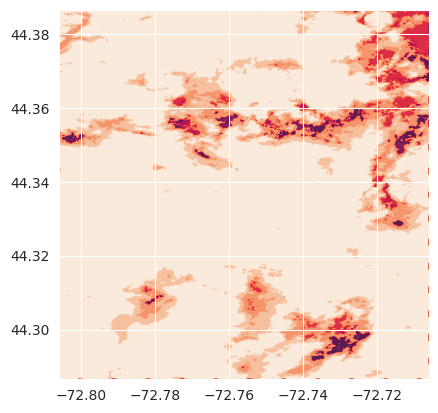

<Axes: >

In [ ]:
i=20
print(os.path.basename(df_files_raster_SCL['files'][i-1]))
df_freq= freq_array(ds_SCL,band_number=i)
print(df_freq)

plot.show((ds_SCL,i)) #can pick a band this way

In [ ]:
df_files_raster_SCL

,files,date
0,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-02
1,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-07
2,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-12
3,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-17
4,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-22
...,...,...
181,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2023-09-19
182,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2023-09-24
183,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2023-09-29
184,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2023-10-04


In [ ]:

from io import StringIO, BytesIO

text_string = StringIO("""
value,class,HTLM color code
0,No Data (Missing data),#000000
1,Saturated or defective pixel,#ff0000
2,Dark features/Shadows',#2f2f2f
3,Cloud shadows,#643200
4,Vegetation,#00a000
5,Not-vegetated,#ffe65a
6,Water,#0000ff
7,Unclassified,#808080
8,Cloud medium probability,#c0c0c0
9,Cloud high probability,#ffffff
10,Thin cirrus,#64c8ff
11,Snow or ice,#ff96ff
""")
SCL_legend_df = pd.read_csv(text_string, sep=",")
SCL_legend_df

,value,class,HTLM color code
0,0,No Data (Missing data),#000000
1,1,Saturated or defective pixel,#ff0000
2,2,Dark features/Shadows',#2f2f2f
3,3,Cloud shadows,#643200
4,4,Vegetation,#00a000
5,5,Not-vegetated,#ffe65a
6,6,Water,#0000ff
7,7,Unclassified,#808080
8,8,Cloud medium probability,#c0c0c0
9,9,Cloud high probability,#ffffff


Let's raster frequency table to the the reference SCL table with labels to the frequency table. Th evalues that are not present in the raster image are set to NaN. We find that the two top most common category for the timestep 20 are cloud high probablilty and cloud medium probabilit at 76% and 11% respectively. If we were to mask both for both categories, we would only be letf with 13% valid pixels.

In [ ]:
SCL_legend_df = (SCL_legend_df.merge(df_freq,
                                      on='value',
                                     how='left')
                              .assign(percent_count= lambda x: x['count'] *100/ x['count'].sum())
)
SCL_legend_df

,value,class,HTLM color code,count,percent_count
0,0,No Data (Missing data),#000000,1152.0,0.093331
1,1,Saturated or defective pixel,#ff0000,NaN,NaN
2,2,Dark features/Shadows',#2f2f2f,13759.0,1.114702
3,3,Cloud shadows,#643200,2319.0,0.187877
4,4,Vegetation,#00a000,5031.0,0.407593
5,5,Not-vegetated,#ffe65a,25182.0,2.040150
6,6,Water,#0000ff,73.0,0.005914
7,7,Unclassified,#808080,101667.0,8.236674
8,8,Cloud medium probability,#c0c0c0,145191.0,11.762823
9,9,Cloud high probability,#ffffff,939947.0,76.150936


To map quality pixel values, we went through multiple steps:

- computed the frequency unique SCL values for a specific date
- use the reference SCL legend to label the pixels
- created a map using earthy in conjunction to xarray and matplotlib color for legned.


crop_proj_sentinel-2-l2a_assets.SCL.href_20210407.tif


/usr/local/lib/python3.10/dist-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


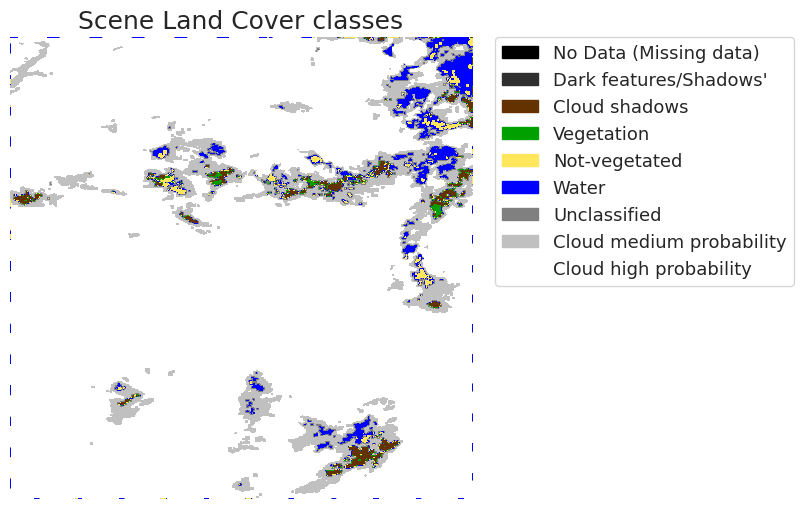

In [ ]:
i=20
print(os.path.basename(df_files_raster_SCL['files'][i-1]))
data_path = df_files_raster_SCL['files'][i-1]
color_list = SCL_legend_df.loc[~(SCL_legend_df['count'].isnull()),'HTLM color code'].tolist()
class_names = SCL_legend_df.loc[~(SCL_legend_df['count'].isnull()),'class'].tolist()
title_str = "Scene Land Cover classes"
sns.set(font_scale=1.5, style="whitegrid")

r_rxr = rxr.open_rasterio(data_path,
                          masked=True).squeeze()
r_rxr = r_rxr.astype('uint8')
classes_rxr = list(np.unique(r_rxr).astype('int'))

cmap_val = ListedColormap(color_list)
f, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(r_rxr,
              cmap = cmap_val)
ax.set(title=title_str)
ep.draw_legend(im,
              titles = class_names,
              classes = classes_rxr)
ax.set_axis_off()
plt.show()

Now let's use the function we created to plot categorical raster. The function takes as input:
- a file path
- color list if None, it will automatically generated
- class names if None, set to class_1, class_2 etc.

/usr/local/lib/python3.10/dist-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


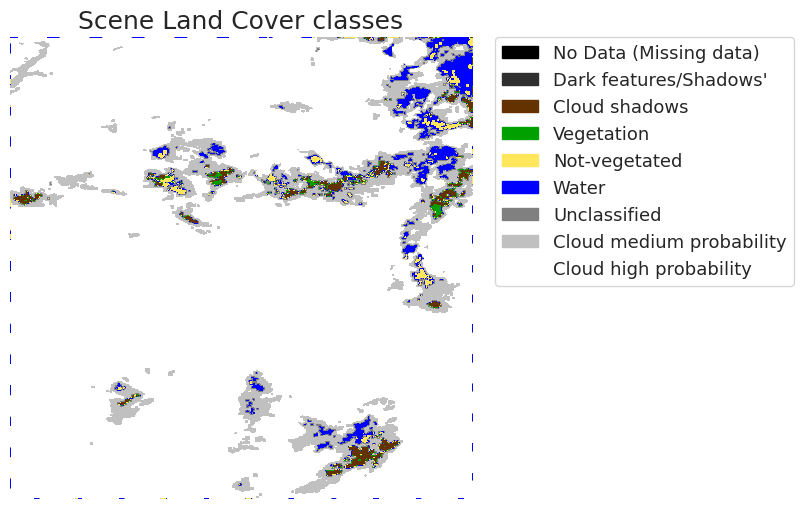

'plotted'

In [ ]:
data_path = df_files_raster_SCL['files'][i-1]
color_list = SCL_legend_df.loc[~(SCL_legend_df['count'].isnull()),'HTLM color code'].tolist()
class_names = SCL_legend_df.loc[~(SCL_legend_df['count'].isnull()),'class'].tolist()
title_str = "Scene Land Cover classes"
plot_raster_categories(in_filename=data_path,
                       color_list=color_list,
                       class_names=class_names,
                       title_str=title_str)


/usr/local/lib/python3.10/dist-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


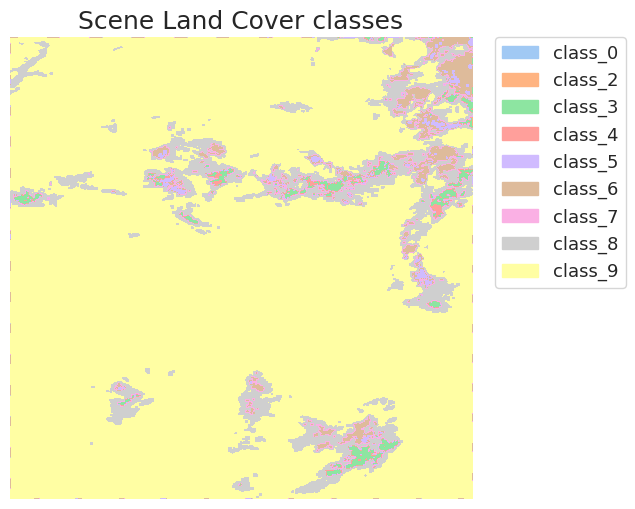

'plotted'

In [ ]:
plot_raster_categories(in_filename=data_path,
                       color_list=None,
                       class_names=None,
                       title_str=title_str)


##6.2 Create quality pixel mask

Let's use the SCL band to mask out pixel that should be NAs in the reflectance bands. We will do this in multiple steps:

1. Create a time series for the quality pixel band SCL
2. Create a time series for the reflectance band we want to mask out.
3. Update time series tif file description with dates
3. Use gdal_calc to mask out pixel value corresponding to
mask_values = [0,1,8,9]
- 0: No Data (Missing data)
- 1: Saturated or defective pixel
- 8: Cloud medium probability
- 9: Cloud high probability

Useful links:
- https://gis.stackexchange.com/questions/286935/calculate-raster-mean-with-gdal-calc-unexpected-result
- #https://www.kaggle.com/code/samanemami/a-complete-tutorial-on-raster-data-analysis



In [ ]:
bands_pattern_val='SCL'
#need to account for the fact that band files are in dates folder
in_dir_files =  os.path.join(in_dir,'sentinel-2-l2a','*')
file_pattern = f'crop_proj_sentinel-2-l2a_*{bands_pattern_val}*.tif'
out_file_SCL, out_file_SCL_vrt, df_files_raster_SCL = generate_time_series_raster(file_pattern=file_pattern,
                                                                                      in_dir=in_dir_files,
                                                                                      out_suffix=bands_pattern_val,
                                                                                      out_dir=".")
print(out_file_SCL)
ds_SCL =rasterio.open(out_file_SCL)
print(ds_SCL.meta)

bands_pattern_val='B08'
#need to account for the fact that band files are in dates folder
in_dir_files =  os.path.join(in_dir,'sentinel-2-l2a','*')
file_pattern = f'crop_proj_sentinel-2-l2a_*{bands_pattern_val}*.tif'
out_file_band, out_file_band_vrt, df_files_raster_band= generate_time_series_raster(file_pattern=file_pattern,
                                                                                      in_dir=in_dir_files,
                                                                                      out_suffix=bands_pattern_val,
                                                                                      out_dir=".")
print(out_file_band)
ds_band =rasterio.open(out_file_band)
ds_band.meta
df_files_raster_band

./SCL_time_series.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1111, 'height': 1111, 'count': 186, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.999999999999984e-05, 0.0, -72.80588972127818,
       0.0, -8.999999999999984e-05, 44.38653872978746)}
./B08_time_series.tif


,files,date
0,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-02
1,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-07
2,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-12
3,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-17
4,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2021-01-22
...,...,...
181,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2023-09-19
182,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2023-09-24
183,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2023-09-29
184,/content/gdrive/MyDrive/Colab Notebooks/Earth_...,2023-10-04


Let's check how to get the information contain in the geotif with gdalinfo. We can see we are missing date information.

In [ ]:
raster_in_filename='SCL_time_series.tif'
list_args =['gdalinfo',
raster_in_filename]
cmd_str = ' '.join([str(elem) for elem in list_args])
print(cmd_str)
import subprocess
env = os.environ.copy() #this is necessary in google colab

#subprocess.run(cmd_str, shell=True, env=env)
output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
output_sub
#https://www.kaggle.com/code/samanemami/a-complete-tutorial-on-raster-data-analysis

gdalinfo SCL_time_series.tif


'Driver: GTiff/GeoTIFF\nFiles: SCL_time_series.tif\nSize is 1111, 1111\nCoordinate System is:\nGEOGCRS["WGS 84",\n    ENSEMBLE["World Geodetic System 1984 ensemble",\n        MEMBER["World Geodetic System 1984 (Transit)"],\n        MEMBER["World Geodetic System 1984 (G730)"],\n        MEMBER["World Geodetic System 1984 (G873)"],\n        MEMBER["World Geodetic System 1984 (G1150)"],\n        MEMBER["World Geodetic System 1984 (G1674)"],\n        MEMBER["World Geodetic System 1984 (G1762)"],\n        MEMBER["World Geodetic System 1984 (G2139)"],\n        ELLIPSOID["WGS 84",6378137,298.257223563,\n            LENGTHUNIT["metre",1]],\n        ENSEMBLEACCURACY[2.0]],\n    PRIMEM["Greenwich",0,\n        ANGLEUNIT["degree",0.0174532925199433]],\n    CS[ellipsoidal,2],\n        AXIS["geodetic latitude (Lat)",north,\n            ORDER[1],\n            ANGLEUNIT["degree",0.0174532925199433]],\n        AXIS["geodetic longitude (Lon)",east,\n            ORDER[2],\n            ANGLEUNIT["degree",0

Let's add the date information in the description so that we can refer  to each band using the date.

In [ ]:
#Let's update the description so we can use it as a band name
filepath=out_file_band
print(filepath)
update_description_gdal(filepath=filepath,
                        list_desc=list_dates)
ds_test = rasterio.open(filepath)
ds_test.descriptions[:5]

./B08_time_series.tif


NameError: name 'list_dates' is not defined

We can create a mask image by reclassifying SCL band values to 0 and 1. Below we use GDAL_calc to set all band values to 0 for values selected: 0,1,8,9

In [ ]:

os.chdir(out_dir)
#generate the formula programatically
mask_values = [0,1,8,9]
input_filename ='SCL_time_series.tif'
input_filename = os.path.basename(df_files_raster_SCL.loc[i,'files'])
print(df_files_raster_SCL.dtypes)
date_val = datetime.strftime((df_files_raster_SCL.loc[i,'date']),'%Y-%m-%d')
date_val_formatted = date_val.replace('-','')
print(input_filename)
output_filename = 'output_mask_test2.tif'
os.chdir(f'sentinel-2-l2a/{date_val_formatted}')
list_args =['gdal_calc.py',
            f'-A {input_filename}',
            '--A_band=1',
            '--calc="(A==0)*0 +', #this is set as no data value so it should be ignored in the calculation (use --hideNoData)
            '(A==1)*0 +',
            '(A==2)*1 +',
            '(A==3)*1 +',
            '(A==4)*1 +',
            '(A==5)*1 +',
            '(A==6)*1 +',
            '(A==7)*1 +',
            '(A==8)*0 +',
            '(A==9)*0 +',
            '(A==10)*1+',
            '(A==11)*1"',
             '--hideNoData',
            '--overwrite',
            '--outfile',
            f'{output_filename}']

cmd_str = ' '.join([str(elem) for elem in list_args])
print(cmd_str)
import subprocess
env = os.environ.copy() #this is necessary in google colab
output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
print(output_sub)
os.chdir(out_dir)
!pwd

files            object
date     datetime64[ns]
dtype: object
crop_proj_sentinel-2-l2a_assets.SCL.href_20210412.tif


FileNotFoundError: [Errno 2] No such file or directory: 'sentinel-2-l2a/20210412'

You can compare the frequency of values in the orginal SCL file which contains 10 unique values. We can see that no data currently contains 1152 pixels.

In [ ]:
data_path_SCL =os.path.join(f'sentinel-2-l2a/{date_val_formatted}',input_filename)
r_SCL = rasterio.open(data_path_SCL).read(1)
freq_array(r_SCL)

,value,count
0,0,1152
1,2,47703
2,3,54381
3,4,70386
4,5,101241
5,6,9702
6,7,160341
7,8,132771
8,9,656614
9,10,30


Let's visulalize the new mask image which contains 0 and 1.

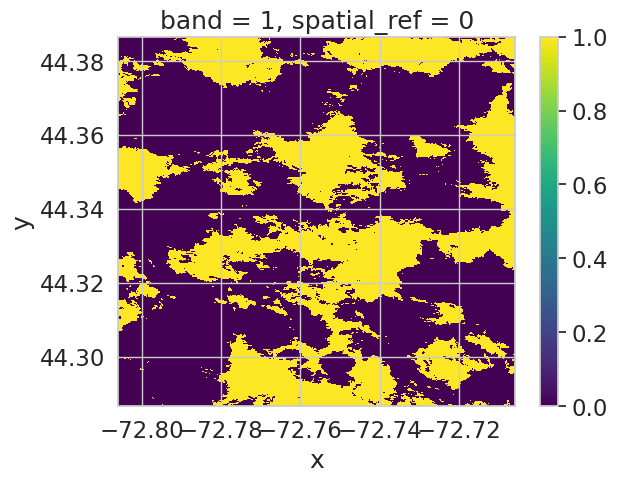

In [ ]:
# Loading TIF file
import rioxarray as rxr
#data_path = 'folder/test_img.tif'
data_path = f'sentinel-2-l2a/{date_val_formatted}/output_mask_test2.tif'
ds = rxr.open_rasterio(data_path,
                          masked=True,
                          cache=False) #masked for nodata and cache to avoid loading in memory
ds = ds.astype('uint16')
ds.sel(band=1).plot.imshow(robust=True) #with image enhancement using 2% percentifle for strchening

The number of masked values (zero) is now 790,537 compared to 1152 earlier.

In [ ]:
data_path_mask = data_path
ds_r_mask = rasterio.open(data_path_mask)
r_mask = ds_r_mask.read(1)
print(ds_r_mask.dtypes)
freq_array(r_mask)

('uint8',)


,value,count
0,0,790537
1,1,443784


##6.3 Apply pixel mask on one image date

To apply the mask value, we can use gdal_calc and read in both the SCL and reflectance band together.
 We will mask ou the following values:

- 0: No Data (missing data)
- 1: Saturated or defective pixel
- 8: Cloud medium probability
- 9: Cloud high probability

The operation is similar to the gdal_calc command used previously but we multiply the masked values from the SCL band (file A) by the reflectance values (file B).

In [ ]:
mask_values = [0,1,8,9]
print(mask_values)
df_legend_SCL =generate_qa_table_sentinel2()

os.chdir(out_dir)

#generate the formula programatically
input_filename ='SCL_time_series.tif'
input_filename_qa = os.path.basename(df_files_raster_SCL.loc[i,'files'])
input_filename_var = os.path.basename(df_files_raster_band.loc[i,'files'])
output_filename = 'output_mask_test_var.tif'
os.chdir(f'sentinel-2-l2a/{date_val_formatted}')
list_args =['gdal_calc.py',
            f'-A {input_filename_qa}',
            f'-B {input_filename_var}',
            '--A_band=1',
            '--B_band=1',
            '--calc="(A==0)*0*B +',
            '(A==1)*0*B +',
            '(A==2)*1*B +',
            '(A==3)*1*B +',
            '(A==4)*1*B +',
            '(A==5)*1*B +',
            '(A==6)*1*B +',
            '(A==7)*1*B +',
            '(A==8)*0*B +',
            '(A==9)*0*B"',
            '--hideNoData',
            '--overwrite',
            '--outfile',
            f'{output_filename}']

cmd_str = ' '.join([str(elem) for elem in list_args])

print(cmd_str)
import subprocess
env = os.environ.copy() #this is necessary in google colab

output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
print(output_sub)
os.chdir(out_dir)
!pwd

[0, 1, 8, 9]
gdal_calc.py -A crop_proj_sentinel-2-l2a_assets.SCL.href_20210412.tif -B crop_proj_sentinel-2-l2a_assets.B08.href_20210412.tif --A_band=1 --B_band=1 --calc="(A==0)*0*B + (A==1)*0*B + (A==2)*1*B + (A==3)*1*B + (A==4)*1*B + (A==5)*1*B + (A==6)*1*B + (A==7)*1*B + (A==8)*0*B + (A==9)*0*B" --hideNoData --overwrite --outfile output_mask_test_var.tif
0.. 0.. 1.. 1.. 2.. 3.. 3.. 4.. 5.. 5.. 6.. 6.. 7.. 8.. 8.. 9.. 10.. 10.. 11.. 11.. 12.. 13.. 13.. 14.. 15.. 15.. 16.. 16.. 17.. 18.. 18.. 19.. 20.. 20.. 21.. 22.. 22.. 23.. 23.. 24.. 25.. 25.. 26.. 27.. 27.. 28.. 28.. 29.. 30.. 30.. 31.. 32.. 32.. 33.. 33.. 34.. 35.. 35.. 36.. 37.. 37.. 38.. 38.. 39.. 40.. 40.. 41.. 42.. 42.. 43.. 44.. 44.. 45.. 45.. 46.. 47.. 47.. 48.. 49.. 49.. 50.. 50.. 51.. 52.. 52.. 53.. 54.. 54.. 55.. 55.. 56.. 57.. 57.. 58.. 59.. 59.. 60.. 61.. 61.. 62.. 62.. 63.. 64.. 64.. 65.. 66.. 66.. 67.. 67.. 68.. 69.. 69.. 70.. 71.. 71.. 72.. 72.. 73.. 74.. 74.. 75.. 76.. 76.. 77.. 77.. 78.. 79.. 79.. 80.. 81.. 81.. 82

Let's visualize the masked reflectance image. All pixels matching the mask values (0,1,8,9) were set to 0  and other reflectance values remained the same.

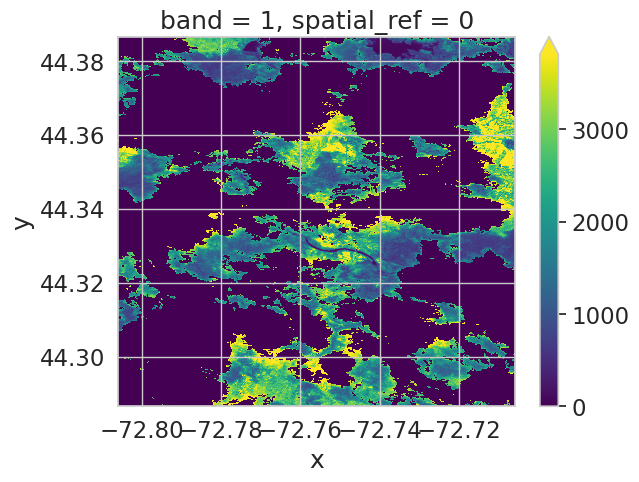

In [ ]:
output_filename = 'output_mask_test_var.tif'
# Loading TIF file
import rioxarray as rxr
data_path = f'sentinel-2-l2a/{date_val_formatted}/{output_filename}'
ds_var = rxr.open_rasterio(data_path,
                          masked=True,
                          cache=False) #masked for nodata and cache to avoid loading in memory
#ds = ds.astype('uint16')
ds_var
ds_var.sel(band=1).plot.imshow(robust=True) #with image enhancement using 2% percentifle for strchening

We note that in the figure above the masked image of relectance has not coded value zero as no data. When running gdal_calc we must also set the output no-data value to zero. This will be done in the next section when creating a function for masking pixels.

##6.4 Use function to mask low qa pixel across time series dates

We created a function to perform all the steps described in the previous selction.  The function called generate_apply_qa_raster_sentinel2 takes as input parameters:

- mask_values: a list of values to mask
- input_filename_qa: file contain quality values to create a mask
- input_filename_var: file containing variable value e.g. reflectance to be masked
- output_filename: output file name
- in_dir: input directory where relevant files are located
- max_val: maximum valid range
- out_dir: output directory where to store output file

We run this function for every date and selected reflectance band (green B03, red B04, NIR B08).

In [ ]:
generate_masked_qa_files = True
max_valid_range = 10000
mask_values = [0,1,8,9]

#max_valid_range = None
list_band_pattern = ['B03','B04','B08']
list_outputs_stats_df =[]

if generate_masked_qa_files is True:

  start_time = datetime.now()
  #crop_proj_sentinel-2-l2a_assets.B04.href_20210110.tif

  for bands_pattern_val in list_band_pattern:
     #use '*' in the path to look for all the files in separate date folders
    in_dir_files =  os.path.join(out_dir,image_collections,'*')
    file_pattern = f'crop_proj_sentinel-2-l2a_*{bands_pattern_val}*.tif'
    out_file_raster, out_file_vrt, df_files_raster_band = generate_time_series_raster(file_pattern=file_pattern,
                                                                                        in_dir=in_dir_files,
                                                                                        dstNodata_val=None,
                                                                                        srcNodata_val=None,
                                                                                        out_suffix=None,
                                                                                        out_dir=".")
    #run time is 32 min 14s for year 2016 through 2018 res res 0.00009
    #run time is 28 min 49s for for year 2016 through 2018 res res 0.00009
    list_output_files = []
    list_stats_df = []
    for date_val in list_dates:

      input_filename_var = os.path.basename(df_files_raster_band.loc[df_files_raster_band['date']==date_val,'files'].values[0])
      input_filename_qa = os.path.basename(df_files_raster_SCL.loc[df_files_raster_SCL['date']==date_val,'files'].values[0])
      out_filename = (df_files_raster_band.loc[df_files_raster_band['date']==date_val,'files'].values[0])
      out_filename = Path(out_filename).stem
      out_filename = f'masked_{out_filename}.tif'
      #out_filename
      os.chdir(out_dir)


      data_val_formatted = date_val.replace("-","")

      cmd_str,output_filename = generate_apply_qa_raster_sentinel2(mask_values=mask_values,
                                        input_filename_qa=input_filename_qa,
                                        input_filename_var=input_filename_var,
                                        output_filename=out_filename,
                                        in_dir= os.path.join(image_collections,data_val_formatted),
                                        max_val = max_valid_range,
                                        out_dir= os.path.join(image_collections,data_val_formatted)
                                        )

      ## Now set no data and description + recalculate stats after that

      update_nodata_val_raster(output_filename,band_val=1,nodata_val=0)
      df_stats = update_raster_band_stats(in_filename=output_filename,
                                      band_val=1)

      list_output_files.append(output_filename)
      list_stats_df.append(df_stats)

    #
    stats_df = pd.concat(list_stats_df)
    stats_df['date']=list_dates
    stats_df['date'] = (pd.to_datetime(stats_df['date']))
    #df_files_raster = df_files_raster.sort_values(by='date')
    stats_df = stats_df.reset_index(drop=True)
    stats_df['file'] = list_output_files
    stats_df['band']=bands_pattern_val
    list_outputs_stats_df.append(stats_df)

  end_time = datetime.now()
  duration = end_time - start_time
  print(f'Duration: {duration}')
  #To compute time duration in minutes:
  (duration.seconds)/60

os.chdir(out_dir)

<ipython-input-24-78b8d7af0613>:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df_files_raster['date'] = (df_files_raster['files'].str.split("_").str[-1]).str.replace(".tif","")
<ipython-input-24-78b8d7af0613>:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df_files_raster['date'] = (df_files_raster['files'].str.split("_").str[-1]).str.replace(".tif","")
<ipython-input-24-78b8d7af0613>:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df_files_raster['date'] = (df_files_raster['files'].str.split("_").str[-1]).str.replace(".tif","")


Duration: 0:11:02.587787


During the masking process, we also updated the statistic values in the tif files since we masked the image and set a valid range. Let's take  at the updated values.

In [ ]:
stats_df = list_outputs_stats_df[2] #let's take a look at band 08 which NIR
print(stats_df.head(5))
stats_df['mean'].value_counts()

      min      max         mean          std       date  \
0  2874.0  10000.0  6120.325599  1643.277490 2021-01-02   
1   938.0  10000.0  3550.380486  1156.090605 2021-01-07   
2    62.0  10000.0  2877.579965  1447.169251 2021-01-12   
3  1456.0  10000.0  6369.971154  1842.791753 2021-01-17   
4  1834.0   9992.0  4711.345820  1639.153344 2021-01-22   

                                                file band  
0  masked_crop_proj_sentinel-2-l2a_assets.B08.hre...  B08  
1  masked_crop_proj_sentinel-2-l2a_assets.B08.hre...  B08  
2  masked_crop_proj_sentinel-2-l2a_assets.B08.hre...  B08  
3  masked_crop_proj_sentinel-2-l2a_assets.B08.hre...  B08  
4  masked_crop_proj_sentinel-2-l2a_assets.B08.hre...  B08  


0.000000       41
6120.325599     1
2102.475283     1
4515.400597     1
7891.082004     1
               ..
1528.074551     1
3835.905682     1
1559.271448     1
1610.011190     1
3433.952177     1
Name: mean, Length: 146, dtype: int64

Let's set min values 0 to NA since these represent no data or masked data. We can now plot the mean.

datetime64[ns]


<Axes: title={'center': 'Mean for entire raster'}, xlabel='date'>

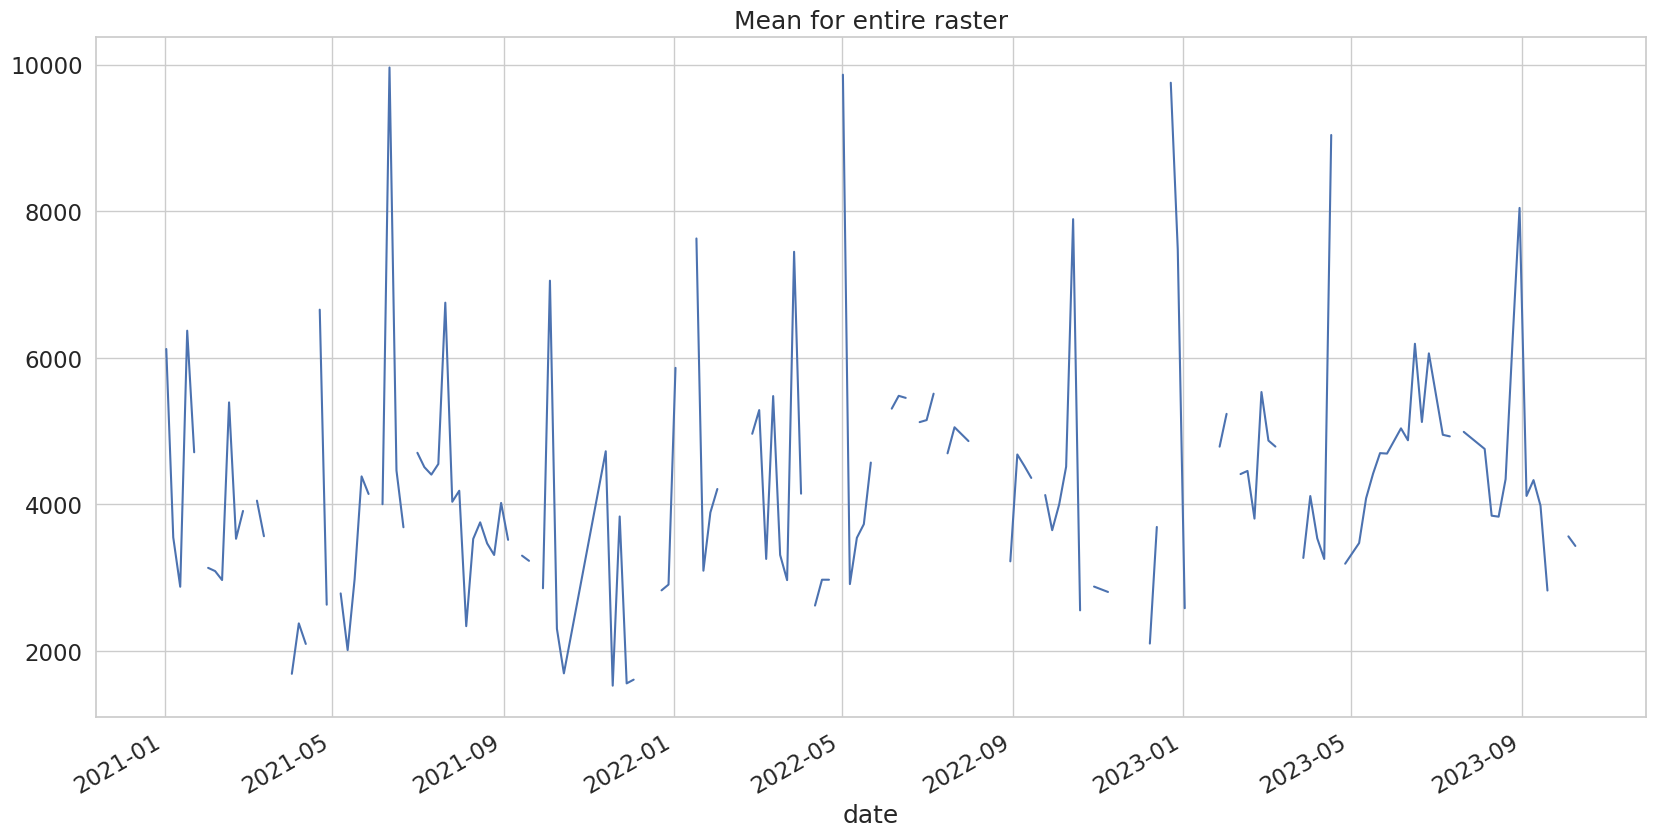

In [ ]:
stats_df.replace(0,np.NaN,inplace=True)
print(stats_df['date'].dtype)
stats_df = stats_df.set_index('date')
stats_df['mean'].plot(figsize=(20, 10),
                             title='Mean for entire raster')

masked_crop_proj_sentinel-2-l2a_assets.B08.href_20210412.tif
20210412


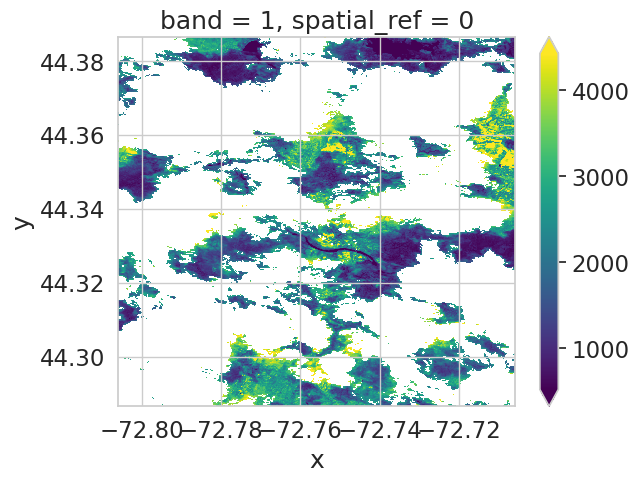

In [ ]:
band_val = list_band_pattern[2]
output_filename = f'masked_crop_proj_sentinel-2-l2a_assets.{band_val}.href_{date_val_formatted}.tif'
print(output_filename)
print(date_val_formatted)
# Loading TIF file
# use rioxarray to read the data

data_path = f'sentinel-2-l2a/{date_val_formatted}/{output_filename}'
ds_var = rxr.open_rasterio(data_path,
                          masked=True,
                          cache=False) #masked for nodata and cache to avoid loading in memory
ds_var
ds_var.sel(band=1).plot.imshow(robust=True) #with image enhancement using 2% percentifle for strchening

#8.References


Obregón, M.A., Rodrigues, G., Costa, M.J., et al. (2019). Validation of ESA Sentinel-2 L2A aerosol optical thickness and columnar water vapour during 2017-2018. Remote Sensing, 11(14), 1649. https://doi.org/10.3390/rs11141649

Schläpfer, D., Borel, C.C., Keller, J., et al. (1998). Atmospheric precorrected differential absorption technique to retrieve columnar water vapor. Remote Sensing of Environment, 65(3), 353-366. https://doi.org/10.1016/S0034-4257(98)00044-3.

Gascon F., Bouzinac C., Thépaut O., et al. (2017). Copernicus Sentinel-2A calibration and products validation status. Remote Sensing, 9(6), 584. https://doi.org/10.3390/rs9060584


In [ ]:
############################# END OF SCRIPT ###################################